In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#import datetime as dt
df = pd.read_csv('purchases.csv')
df['user_id'] = df['user_id'].astype(str)

In [25]:
#get a feel for the data set
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51243 entries, 0 to 51242
Data columns (total 3 columns):
user_id             51243 non-null object
purchase_amount     51243 non-null float64
transaction_date    51243 non-null object
dtypes: float64(1), object(2)
memory usage: 1.2+ MB


In [26]:
#see basic summary statistics
df.describe()

,purchase_amount
count,51243.000000
mean,62.337195
std,156.606801
min,5.000000
25%,25.000000
50%,30.000000
75%,60.000000
max,4500.000000


## We can see our interquartile range is from 25 to 60, but because our standard deviation is so high, a cutoff of 60 for big spending transactions is pretty meaningless (especially when we have 100's of customers spending more than 1000 in one transaction). That said, we will aggregate based on sum total of money spent, and run our analysis from there.

In [27]:
df.groupby('user_id').max().purchase_amount.sort_values(ascending = False).head(100)

user_id
246480    4500.00
222740    4500.00
141340    4419.00
39920     4000.00
98550     4000.00
216730    4000.00
126120    4000.00
187390    4000.00
181800    4000.00
247870    4000.00
112000    4000.00
98790     4000.00
193210    3627.10
147510    3500.00
76440     3500.00
13610     3100.00
162530    3000.00
84010     3000.00
215460    3000.00
84050     3000.00
123480    3000.00
32800     3000.00
74080     3000.00
215930    3000.00
181920    3000.00
164930    3000.00
123990    3000.00
156280    3000.00
212980    3000.00
246530    2500.00
           ...   
140600    1500.00
150370    1500.00
191560    1500.00
248110    1500.00
166760    1500.00
20200     1500.00
73170     1500.00
197420    1500.00
211990    1488.00
50790     1400.00
158690    1400.00
48080     1305.00
203460    1282.00
157770    1268.00
211970    1230.00
200620    1200.00
126430    1200.00
83120     1200.00
182050    1200.00
134590    1200.00
234230    1184.21
223100    1129.22
96920     1100.00
191520    1080.00
21

In [28]:
#change our date to datetime (the python date format)
df['transaction_date'] = pd.to_datetime(df['transaction_date'])
#get weekday, year, and month from the data. I'm gonna run a quick random forest using this info to see if date affects
#amount spent
df['weekday'] = df['transaction_date'].dt.weekday

In [29]:
df['year']=df['transaction_date'].dt.year
df['month']=df['transaction_date'].dt.month

In [30]:
#group purchase by weekday and sum the amount spent
df.groupby('weekday').purchase_amount.sum()

weekday
0     81909.00
1    403088.66
2    832852.47
3    560034.88
4    727430.95
5    481037.66
6    107991.28
Name: purchase_amount, dtype: float64

In [31]:
#group purchase by weekday and count the order
df.groupby('weekday').purchase_amount.count()


weekday
0      955
1     5626
2    13970
3     8292
4    12828
5     8023
6     1549
Name: purchase_amount, dtype: int64

## Ran a check to ensure that all of the purchases at least have a relatively normal size (maybe our biggest clients happen to close dealds on Wednesdays, or something along those lines). Looks like Sum and Count are pretty interchangeable.

In [32]:
#sum to get the various orders by id, and then group further by all of the dates. This will get us all the orders
#done by various customers grouped up all the way to day
df_agged = df.groupby(['user_id','year','month','weekday']).sum().purchase_amount.head(500).reset_index()
#we also find out who our biggest customers are in this dataframe
df_big_spend = df.groupby('user_id').purchase_amount.sum()

In [33]:
df_big_spend = df_big_spend.reset_index().set_index('user_id')

In [34]:
df_big_spend.info()

<class 'pandas.core.frame.DataFrame'>
Index: 18417 entries, 10 to 99990
Data columns (total 1 columns):
purchase_amount    18417 non-null float64
dtypes: float64(1)
memory usage: 287.8+ KB


In [35]:
#any customer who has spent a sum total of $1000 or more will be considered a big spender
df_big_spend['big_spender'] = np.where(df_big_spend['purchase_amount']>=1000, 1, 0)

In [36]:
#merge our big spenders and our amount spent
fin_df = df_big_spend['big_spender'].reset_index().merge(df_agged, on='user_id',how = 'right')

In [37]:
#here we are creating a random forest that trains on day of week, month, and year, 
#and figures out if they can be used to predict a big spender
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, precision_recall_curve, classification_report, confusion_matrix
from sklearn.cross_validation import train_test_split
from sklearn.ensemble import RandomForestClassifier


#split df in day, month, and year for X
X = fin_df.iloc[:,2:]
X = X.dropna()
#big spender is our target
y = fin_df['big_spender']
y=y.dropna()

#initialize forest
rf = RandomForestClassifier()

#here are our parameters
param_grid = {"max_depth": [None,1,2,3,4],     
         'n_estimators': [1,2,3] }

#split X into train and test samples
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = .3)
#perform a grid search to ensure we are using the best parameters
rf_cv = GridSearchCV(rf, param_grid, cv = 5)
#train on our train data
rf_cv.fit(x_train, y_train)

#predict on out test
prediction = rf_cv.predict(x_test)

print("Tuned Forest classifier paramters: {}".format(rf_cv.best_params_))
print("Tuned Forest classifier score: {}".format(rf_cv.best_score_))

#check our predicition against out y values
print('accuracy Score %f' %accuracy_score(y_test,prediction))
#Adding in a confusion matrix and ROC curve 
print('Confusion Matrix:')
print(confusion_matrix(y_test, prediction))




#seemed to do pretty well. We can now use this model to check new customers. It's probably not going to be
#an incredible model or anything, but I figured I'd make it to show I can work a random forest.

Tuned Forest classifier paramters: {'n_estimators': 1, 'max_depth': 3}
Tuned Forest classifier score: 0.925714285714
accuracy Score 0.913333
Confusion Matrix:
[[130   6]
 [  7   7]]


In [38]:
df_big_spend = df_big_spend.sort('purchase_amount',ascending=False)


/Users/jackdwyer/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:1: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  if __name__ == '__main__':


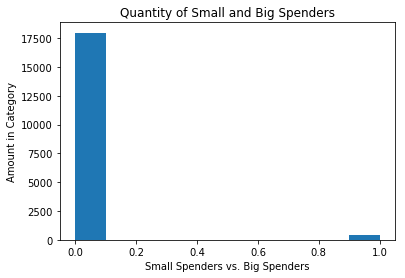

In [39]:
plt.hist(df_big_spend['big_spender'])
plt.ylabel('Amount in Category')
plt.xlabel('Small Spenders vs. Big Spenders')
plt.title('Quantity of Small and Big Spenders')
plt.show()


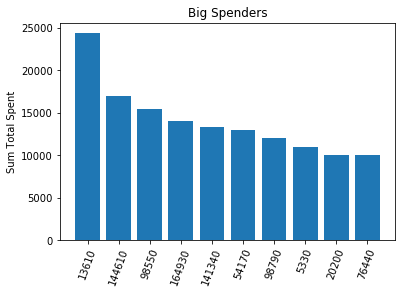

In [40]:
#graphing the 10 biggest accounts
df_big_spend = df_big_spend.reset_index()
x = df_big_spend.user_id.head(10)
y = df_big_spend.purchase_amount.head(10)

#bar plots want a list of integers for their x-values
x_r = range(10)


plt.bar(x_r,y, align='center')

#bring in the labels (names) and rotate the labels to make them easy to read
plt.xticks(x_r,x, rotation = 70)
plt.title('Big Spenders')
plt.ylabel('Sum Total Spent')


plt.show()

In [41]:
#displaying the 25 biggest accounts
df_big_spend.head(25).set_index('user_id')

,purchase_amount,big_spender
user_id,,
13610,24350.0,1
144610,17000.0,1
98550,15507.0,1
164930,14000.0,1
141340,13351.0,1
54170,13000.0,1
98790,12000.0,1
5330,10975.0,1
20200,10100.0,1
